In [1]:
# Load libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.integrate

In [19]:
################################# 
######## Define the model ######
#################################

# Return observable given parameter
def charged_hadron_multiplicity(params):
    
    norm=params['norm']
    eta_over_s_eff=params['eta_over_s_eff']
    
    result=100*norm*(1+eta_over_s_eff)      #<====================================================
    
    return result

# Return observable given parameter
def charged_hadron_v2(params):
    
    norm=params['norm']
    eta_over_s_eff=params['eta_over_s_eff']
    
    result=0.04/(1+6*eta_over_s_eff)+0.0003*norm              #<=========================================================
    
    return result


# Dictionary of parameters
# "label" is used for plotting purposes
# "range" is the allowed range of the parameter (a simple uniform "prior")
# "truth" is the value of the parameters used for the closure test
parameter_d={
    'norm':{
        "label":"Normalization of energy deposition",
        "range":[6,12],
        "truth":10.
    },
    'eta_over_s_eff':{
        "label":r"Effective $\eta/s$",
        "range":[.01,.3],
        "truth":0.12
    }
}

# Observable dictionary
obs_d={
    "multiplicity":{
        'fct':charged_hadron_multiplicity,
        'label':r'$dN_{ch}/d\eta$',
        'fake_exp_rel_uncert':0.05,
        'theoretical_relative_uncertainty':0.05
    },
    "v2":{
        'fct':charged_hadron_v2,
        'label':r'$v_2\{2\}$',
        'fake_exp_rel_uncert':0.05,
        'theoretical_relative_uncertainty':0.05
    },
    
}

In [20]:
#########################
#### Get the "data" #####
#########################

# Data dictionary
data_d={}

# This will be a "closure test": we use the model to generate "data"
# The Bayesian parameter estimation should be peaked around the true value of the parameters
for obs_name, info_d in obs_d.items():
    
    #
    obs_fct=info_d['fct']
    
    #
    data_d[obs_name]={}
    
    # Parameters
    param_value_list={item:tmp_d['truth'] for (item, tmp_d) in parameter_d.items() }
    
    tmp_value=obs_fct(param_value_list)
    data_d[obs_name]['mean']=tmp_value
    
    fake_exp_rel_uncert=info_d['fake_exp_rel_uncert']
        
    data_d[obs_name]['uncert']=fake_exp_rel_uncert*tmp_value

print(data_d)
print(list(parameter_d.keys()))

{'multiplicity': {'mean': 1120.0, 'uncert': 56.0}, 'v2': {'mean': 0.02625581395348837, 'uncert': 0.0013127906976744185}}
['norm', 'eta_over_s_eff']


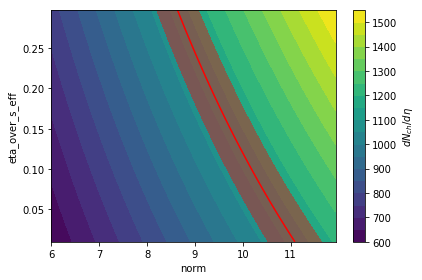

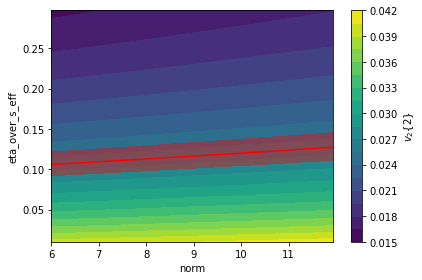

In [21]:
#########################
#### Plot the "data" #####
#########################

for obs_name, info_d in obs_d.items():

    # Function that returns the value of an observable
    obs_fct=info_d['fct']
    
    # Label for the observable
    obs_label=info_d['label']
    
    # Data
    tmp_data_d=data_d[obs_name]
    data_mean=tmp_data_d['mean']
    data_uncert=tmp_data_d['uncert']
    
    # Info about parameters
    param_name_list=list(parameter_d.keys())
    
    x_label=param_name_list[0]
    xmin, xmax = parameter_d[x_label]['range']
    
    y_label=param_name_list[1]
    ymin, ymax = parameter_d[y_label]['range']
    
    
    # Plot what the observable looks like over the parameter prior
    plt.figure()
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Compute the posterior for a range of values of the parameter "x"
    x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)
    y_range=np.arange(ymin, ymax, (ymax-ymin)/100.)

    x_mesh, y_mesh =  np.meshgrid(x_range, y_range, sparse=False, indexing='ij')

    z_list = [ obs_fct({x_label:x_val, y_label:y_val}) for (x_val,y_val) in zip(x_mesh,y_mesh) ]

    # Plot the posterior
    #plt.plot(x_range, y_list, "-", color='black', lw=4)
    #surf = ax.plot_surface(x_mesh, y_mesh, z_list, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    cs = plt.contourf(x_mesh, y_mesh, z_list, 20)

    cbar = plt.colorbar(cs,label=obs_label) 

    # Plot the "data"
    cs2 = plt.contour(x_mesh, y_mesh, z_list, levels=[data_mean],colors='r')
    cs3 = plt.contourf(x_mesh, y_mesh, z_list, levels=[data_mean-data_uncert,data_mean+data_uncert],colors='r',alpha=.4)

    plt.tight_layout()
    plt.show()

In [32]:
########################
# Get the calculations #
########################

calc_d={}

for obs_name, info_d in obs_d.items():

    # Number of points used for the "emulator"
    number_design_emulator=20                #<=========================================================

    # Function that returns the value of an observable
    obs_fct=info_d['fct']
        
    # Info about parameters
    param_name_list=list(parameter_d.keys())
    
    x_label=param_name_list[0]
    xmin, xmax = parameter_d[x_label]['range']
    
    y_label=param_name_list[1]
    ymin, ymax = parameter_d[y_label]['range']

    # For simplicity, we sample the emulator uniformly
    x_list=np.linspace(xmin,xmax,num=number_design_emulator)
    y_list=np.linspace(ymin,ymax,num=number_design_emulator)

    x_mesh, y_mesh =  np.meshgrid(x_list, y_list, sparse=False, indexing='ij')
    
    calculation_mean_list = [ obs_fct({x_label:x_val, y_label:y_val}) for (x_val,y_val) in zip(x_mesh,y_mesh) ]

    relative_uncertainty=info_d['theoretical_relative_uncertainty']
    
    calculation_uncert_list=np.multiply(calculation_mean_list,relative_uncertainty)
    
    calc_d[obs_name]={'x_list':x_list,'y_list':y_list,'mean':calculation_mean_list,'uncert':calculation_uncert_list}

In [43]:
#########################################
# Make interpolator for each observable #
#########################################

emul_d={}

for obs_name, info_d in obs_d.items():

    emul_d[obs_name]={
        'mean':scipy.interpolate.interp2d(calc_d[obs_name]['x_list'], calc_d[obs_name]['y_list'], np.transpose(calc_d[obs_name]['mean']), kind='linear', copy=True, bounds_error=False, fill_value=None),
        'uncert':scipy.interpolate.interp2d(calc_d[obs_name]['x_list'], calc_d[obs_name]['y_list'], np.transpose(calc_d[obs_name]['uncert']), kind='linear', copy=True, bounds_error=False, fill_value=None)
    }
    
    

# Does the emulator work?
#x_test=xmin+0.2*(xmax-xmin)                     #<=========================================================
#y_test=ymin+0.6*(ymax-ymin)                     #<=========================================================
#print(observable_1(x_test,y_test))
#print(emulator_calc_1(x_test,y_test))
#print(observable_2(x_test,y_test))
#print(emulator_calc_2(x_test,y_test))

In [50]:
#########################
# Compute the posterior #
#########################

# We assume uniform priors for this example
# Here 'x' is the only model parameter
def prior(params):
    
    return 1


# Under the approximations that we're using, the posterior is
# exp(-1/2*\sum_{observables, pT} (model(observable,pT)-data(observable,pT))^2/(model_err(observable,pT)^2+exp_err(observable,pT)^2)

# Here 'x' is the only model parameter
def likelihood(params, data):

    res=0.0

    # Sum over observables
    for obs_name in obs_d.keys():
        
        emulator_calc=emul_d[obs_name]['mean']
        emulator_uncert=emul_d[obs_name]['uncert']
        
        data_mean=data[obs_name]['mean']
        data_uncert=data[obs_name]['uncert']
        
        # Vectorize the emulators
        emulator_calc_vec = np.vectorize(emulator_calc)
        emulator_uncert_vec = np.vectorize(emulator_uncert)

        # Info about parameters
        param_name_list=list(parameter_d.keys())
        x_label=param_name_list[0]
        x_value=params[x_label]
    
        y_label=param_name_list[1]
        y_value=params[y_label]

        tmp_model_mean=emulator_calc_vec(x_value,y_value)
        tmp_model_uncert=emulator_uncert_vec(x_value,y_value)

        tmp_data_mean=data_mean
        tmp_data_uncert=data_uncert

        res+=np.power(tmp_model_mean-tmp_data_mean,2)/(tmp_model_uncert*tmp_model_uncert+tmp_data_uncert*tmp_data_uncert)

    res*=-0.5

    return np.exp(res)


#
def posterior(params,data):
    
    return prior(params)*likelihood(params,data)


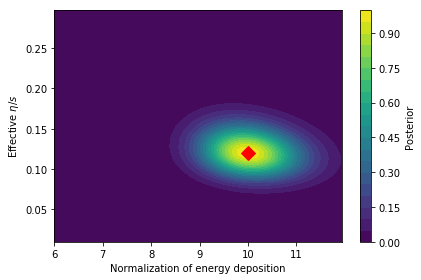

In [57]:
##################
# Plot posterior #
##################


# Info about parameters
param_name_list=list(parameter_d.keys())

x_param_name=param_name_list[0]
xmin, xmax = parameter_d[x_param_name]['range']
x_truth = parameter_d[x_param_name]['truth']
x_label=parameter_d[x_param_name]['label']

y_param_name=param_name_list[1]
ymin, ymax = parameter_d[y_param_name]['range']
y_truth = parameter_d[y_param_name]['truth']
y_label=parameter_d[y_param_name]['label']

plt.figure()
plt.xscale('linear')
plt.yscale('linear')
#plt.xlim(0,2)
#plt.ylim(1e-5,1e2)
plt.xlabel(x_label)
plt.ylabel(y_label)

# Compute the posterior for a range of values of the parameter "x"
x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)
y_range=np.arange(ymin, ymax, (ymax-ymin)/100.)

x_mesh, y_mesh =  np.meshgrid(x_range, y_range, sparse=False, indexing='ij')

posterior_array = [ posterior({x_param_name:x_val, y_param_name:y_val},data_d) for (x_val,y_val) in zip(x_mesh,y_mesh) ]

# Plot the posterior
#plt.plot(x_range, y_list, "-", color='black', lw=4)
#surf = ax.plot_surface(x_mesh, y_mesh, z_list, cmap=cm.coolwarm, linewidth=0, antialiased=False)
cs = plt.contourf(x_mesh, y_mesh, posterior_array, 20)

cbar = plt.colorbar(cs,label="Posterior") 

#cs2 = plt.contour(x_mesh, y_mesh, z_list, levels=data_mean,colors='r')
#cs3 = plt.contour(x_mesh, y_mesh, z_list, levels=[data_mean_1-data_uncert_1,data_mean_1+data_uncert_1], colors='r')
#cs4 = plt.contour(x_mesh, y_mesh, z_list, levels=[data_mean_2-data_uncert_2,data_mean_2+data_uncert_2], colors='r')

plt.plot([x_truth], [y_truth],"D",color='red',ms=10)

#plt.legend(loc='upper right',fontsize=16)
plt.tight_layout()
plt.show()

/home/jfpaquet/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


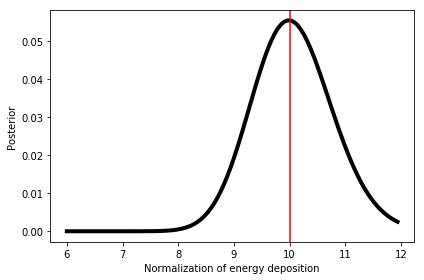

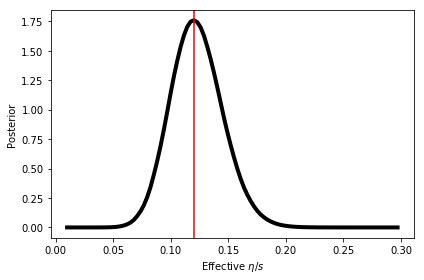

In [59]:
###############################
# Plotting marginal posterior #
###############################

# Posterior vs x
plt.figure()
plt.xscale('linear')
plt.yscale('linear')
#plt.xlim(0,2)
#plt.ylim(1e-5,1e2)
plt.xlabel(x_label)
plt.ylabel(r'Posterior')

# The marginal posterior for a parameter is obtained by integrating over a subset of other model parameters

# Compute the posterior for a range of values of the parameter "x"
x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)

posterior_list = [ scipy.integrate.quad(lambda y_val: posterior({x_param_name:x_val, y_param_name:y_val},data_d),ymin,ymax)[0] for x_val in x_range ]

plt.plot(x_range, posterior_list, "-", color='black', lw=4)

plt.axvline(x=x_truth,color='red')

#plt.legend(loc='upper right',fontsize=16)
plt.tight_layout()
plt.show()


# Posterior vs y
plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(y_label)
plt.ylabel(r'Posterior')

# Compute the posterior for a range of values of the parameter "x"
y_range=np.arange(ymin, ymax, (ymax-ymin)/100.)

posterior_list = [ scipy.integrate.quad(lambda x_val: posterior({x_param_name:x_val, y_param_name:y_val},data_d),xmin,xmax,limit=100, epsrel=1e-4)[0] for y_val in y_range ]

plt.plot(y_range, posterior_list, "-", color='black', lw=4)

plt.axvline(x=y_truth,color='red')

#plt.legend(loc='upper right',fontsize=16)
plt.tight_layout()
plt.show()
